# This notebook is used to demonstrate a multiclass prediction of skin cancer dataset. The dataset contains 6 different classes of skin lesions, some indicate to different kinds of cancer some indicate benign results. Dataset is heavily imbalanced with highest count in a class being 6705 and lowest being just 115.

# In total it has 10,015 images.

**First step is to mount google drive to the colab notebook using below code
preferably use the available T4 GPU or paid versions**




We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**We can also extract the same dataset directly frm kaggle and unzip it by running the below code in 3 cells. But we would need to do it everytime we refresh the runtime, hence it is easy to access it from drive**

In [2]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [3]:
#dont execute all the time
#!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [4]:
#unzip process
#!unzip skin-cancer-mnist-ham10000.zip

**Import required libraries for further processes**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [8]:
from sklearn.utils import class_weight

In [9]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [10]:
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight

**Read the csv file hmnist_28_28_L.csv from the drive**(download all the other csv files from the kaggle)
**This file contains all the pixel values in grayscale, each row corresponds to 784 pixel values from pixel0000 to pixel0783** **create a collection of symptoms and their numerical representation (0-6)**

In [11]:
collections = { 0 : "Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)",
               1 : "basal cell carcinoma (bcc)",
                2 : " benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)",
                3 : "dermatofibroma (df)",
                4 : "melanoma (mel)",
                5 : "melanocytic nevi (nv)",
                6 : "vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)"}

In [12]:
ds = pd.read_csv('/content/drive/MyDrive/cancer detection/hmnist_28_28_L.csv')

In [13]:
ds.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


**Check for any null values and the number of images belonging to each class**

In [14]:
ds['label'].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [15]:
ds.isnull().sum()

pixel0000    0
pixel0001    0
pixel0002    0
pixel0003    0
pixel0004    0
            ..
pixel0780    0
pixel0781    0
pixel0782    0
pixel0783    0
label        0
Length: 785, dtype: int64

**plot the first 5 images and their corresponding classes**

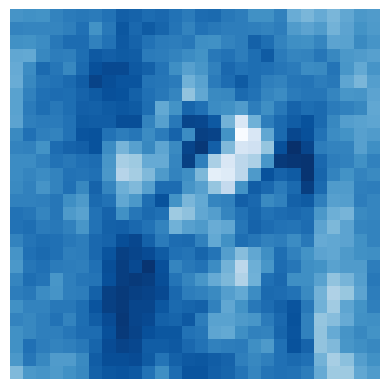

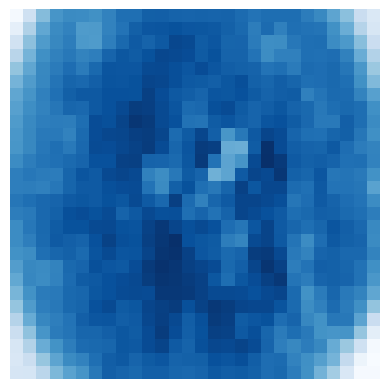

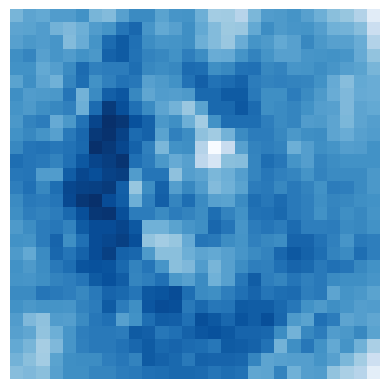

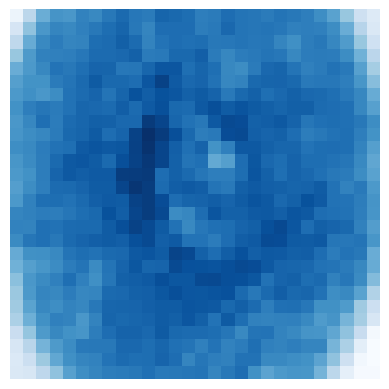

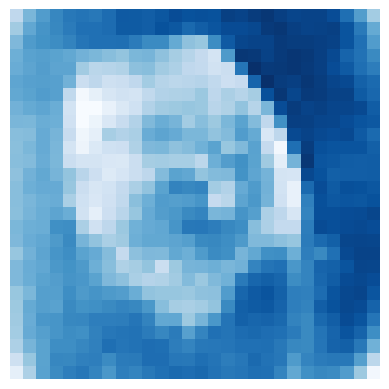

In [16]:
for i in range(0, 5):
  df_arr = ds.iloc[i,:-1].values.reshape(28,28)
  plt.imshow(df_arr, cmap='Blues')
  plt.axis('off')
  plt.show()

**Seperate the dataframe as X and y** **X stands for features y for labels**

In [17]:
X = ds.drop('label', axis=1)
y=ds['label']

**Use SMOTE-Tomeklinks methods combined to balance the imbalanced data. The resulting data will have each 7 classes with 6705 examples.  For SMOTE all minority classes develop synthetic examples and for tomeklinks we use 'Not Majority' where all classes except majority classes are resampled**

In [18]:
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='not majority'))
X, y = resample.fit_resample(X, y)

**We standardise the feature-set of all pixel for accurate values using StandardScaler method**

In [19]:
scl=StandardScaler()
X_std = scl.fit_transform(X)

**Finally we reshape the array to fit the dimension of the CNN to be created this completes our data collection and preprocessing.**

In [20]:
#reshaping X_std for CNN
X_std = np.array(X_std)
X=X_std.reshape(-1, 28, 28, 1)
print(X.shape)
print(y.value_counts())

(46933, 28, 28, 1)
2    6705
3    6705
5    6705
1    6705
0    6705
4    6704
6    6704
Name: label, dtype: int64


**Splitting data into train and test samples**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

**Determine class-weights of each class by using inverse frequency method, I did not use them in end as more accurate results were recieved from SMOTE-Tomeklink data.**

In [22]:
class_frequencies = np.bincount(y_train)
print(class_frequencies)
inverse_class_frequencies = 1.0/np.sqrt(class_frequencies)
class_weights = inverse_class_frequencies/np.sum(inverse_class_frequencies)
class_weights = dict(enumerate(class_weights))
print('class weights are: ', class_weights)

[5044 5023 5014 5063 5038 4976 5041]
class weights are:  {0: 0.1426350464531887, 1: 0.14293289751841748, 2: 0.14306112042759864, 3: 0.14236716049710818, 4: 0.14271995669770868, 5: 0.14360633577995008, 6: 0.1426774826260282}


**Calculated sample weights for a better accuracy for each class**

In [23]:
class_labels = np.unique(y_train)
y_train_int = np.array([np.where(class_labels == label)[0][0] for label in y_train])
sample_weights = compute_sample_weight(class_weight=class_weights, y=y_train_int)
print(sample_weights)

[0.1429329  0.14360634 0.14271996 ... 0.14236716 0.14360634 0.1429329 ]


**Below code is the Convolutional Neural Network Architecture code, It starts with 16 filters and ends at 128 filters, The dense layer has more or less same units of neurons per layer. Dense and Convolutional are joined by averagepooling layer which gives a global output to ANN of the image. I added dropout layers with 20% dropout probability which reduces overfitting at very high-levels, regularizations didn't work well here, hence I used dropouts.**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 16)        80        
                                                                 
 maxpool1 (MaxPooling2D)     (None, 14, 14, 16)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 32)        2080      
                                                                 
 maxpool2 (MaxPooling2D)     (None, 7, 7, 32)          0         
                                                           

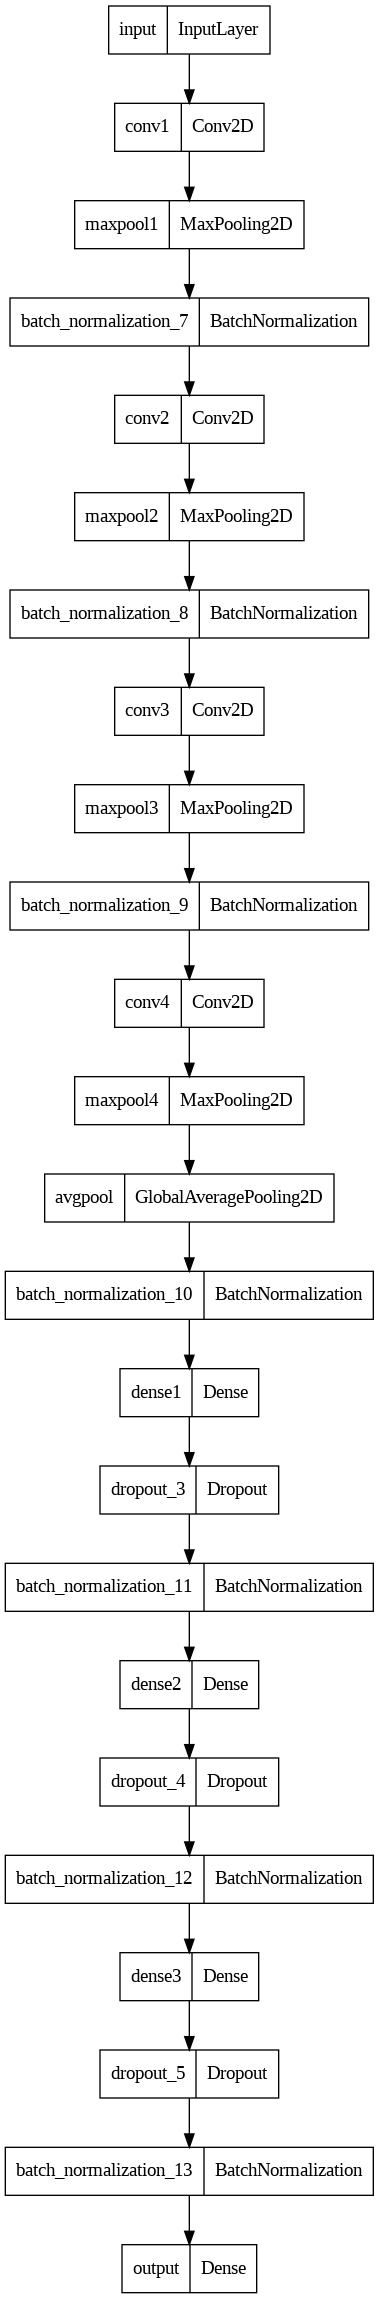

In [35]:
inputs = Input(shape=(28, 28, 1), name='input')


conv1 = Conv2D(filters=16, kernel_size=(2,2), name='conv1', padding='same', strides=(1,1))(inputs)
maxpool1 = MaxPooling2D(pool_size=(2,2), name='maxpool1')(conv1)
batch1=BatchNormalization()(maxpool1)

conv2 = Conv2D(filters=32, kernel_size=(2,2), name='conv2', padding='same', strides=(1,1))(batch1)
maxpool2 = MaxPooling2D(pool_size=(2,2), name='maxpool2')(conv2)
batch2=BatchNormalization()(maxpool2)

conv3 = Conv2D(filters=64, kernel_size=(2,2), name='conv3', padding='same', strides=(1,1))(batch2)
maxpool3 = MaxPooling2D(pool_size=(2,2), name='maxpool3')(conv3)
batch3=BatchNormalization()(maxpool3)


conv4 = Conv2D(filters=128, kernel_size=(2,2), name='conv4',padding='same', strides=(1, 1))(batch3)
maxpool4 = MaxPooling2D( name='maxpool4')(conv4)


avgpool = GlobalAveragePooling2D(name='avgpool')(maxpool4)
batch4=BatchNormalization()(avgpool)


dense1 = Dense(128, activation='relu', name='dense1')(batch4)
dropout1 = Dropout(0.2)(dense1)
batch5=BatchNormalization()(dropout1)


dense2 = Dense(64, activation='relu', name='dense2')(batch5)
dropout2 = Dropout(0.2)(dense2)
batch6=BatchNormalization()(dropout2)


dense3 = Dense(32,  activation = 'relu', name='dense3')(batch6)
dropout3 = Dropout(0.2)(dense3)
batch7=BatchNormalization()(dropout3)


outputs = Dense(7, activation='softmax', name='output')(batch7)

model = Model(inputs=inputs, outputs=outputs)
model.summary()
keras.utils.plot_model(model)

**Compile the model with Adam as the optimizer and a fixed learning rate (0.001)loss function used is sparse categorical crossentropy as it is a Multiclass Calssification, metrics are accuracy as it is simple to use**

In [36]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'], weighted_metrics=[])

**I wanted the best trained model hence I used EarlyStopping technique, as the dataset contains 10,015 images it is a lot of data and for each epoch the validation loss or loss calculated on validation set, shouldn't be too far of the training loss. It also restores best weights i.e. weightss that give least loss.**

In [37]:
model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

Epoch 1/100
880/880 [==============================] - 9s 8ms/step - loss: 1.5324 - accuracy: 0.4090 - val_loss: 1.0908 - val_accuracy: 0.6048
Epoch 2/100
880/880 [==============================] - 8s 9ms/step - loss: 1.0965 - accuracy: 0.5852 - val_loss: 0.8342 - val_accuracy: 0.6955
Epoch 3/100
880/880 [==============================] - 6s 7ms/step - loss: 0.8690 - accuracy: 0.6767 - val_loss: 0.6533 - val_accuracy: 0.7472
Epoch 4/100
880/880 [==============================] - 8s 9ms/step - loss: 0.7349 - accuracy: 0.7280 - val_loss: 0.5745 - val_accuracy: 0.7884
Epoch 5/100
880/880 [==============================] - 6s 7ms/step - loss: 0.6255 - accuracy: 0.7671 - val_loss: 0.4568 - val_accuracy: 0.8251
Epoch 6/100
880/880 [==============================] - 8s 9ms/step - loss: 0.5608 - accuracy: 0.7950 - val_loss: 0.4529 - val_accuracy: 0.8311
Epoch 7/100
880/880 [==============================] - 7s 7ms/step - loss: 0.5089 - accuracy: 0.8163 - val_loss: 0.3600 - val_accuracy: 0.8713

**Plot of Accuracy of the model training**

[]

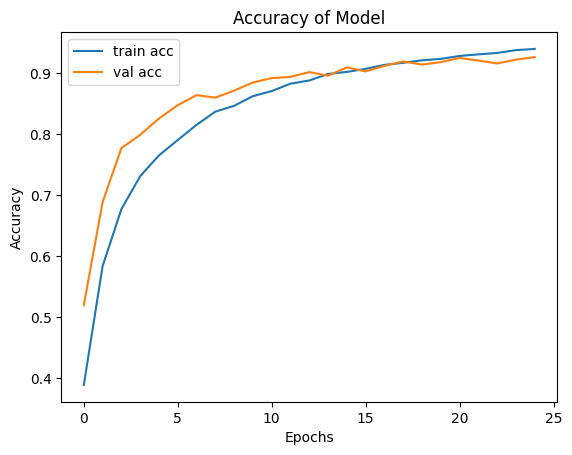

In [27]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Accuracy of Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.plot()

**Plot of Loss during training time**

[]

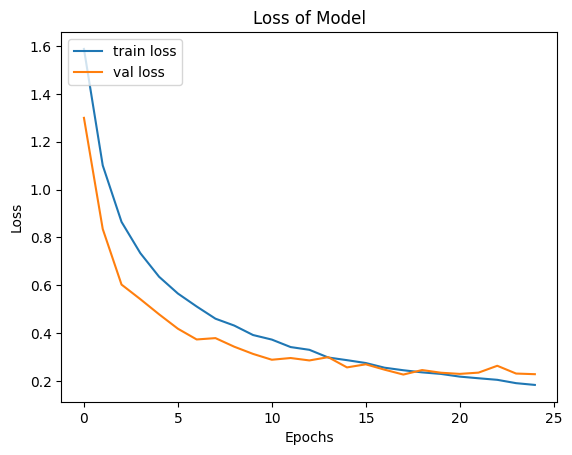

In [28]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss of Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.plot()

**We test the model using X_test set**

In [29]:
x_pred = model.predict(X_test)

367/367 [==============================] - 2s 3ms/step


**Each of the 367 image gave a vector of size 7 we use np.argmax() method to get the index of the highest value, which is inturn the predicted class of the image with highest probability. **

In [30]:
x_pred = np.argmax(x_pred, axis=-1)

**We find the accuracy of the model by comparing it to y_test, we also find the confusion matrix and classification reports**



In [31]:
print('Accuracy of the model is:- ', accuracy_score(x_pred, y_test))

Accuracy of the model is:-  0.9093233339014829


In [32]:
print('confusion matrix:-')
confusion_matrix(y_test, x_pred)

confusion matrix:-


array([[1644,    8,    7,    0,    0,    0,    2],
       [  15, 1641,   13,    1,    9,    2,    1],
       [  28,   34, 1467,    4,   90,    2,   66],
       [   0,    2,    3, 1637,    0,    0,    0],
       [  15,   58,  160,    7, 1136,   42,  248],
       [   1,    1,    1,    0,    6, 1719,    1],
       [   4,    4,   78,    3,  146,    2, 1426]])

**The plotted confusion matrix shows the dark blue diagonal pattern, each box in (0, 0) to (6,6) represents the True positive predictions, rest show the TN, FP, FN in each of the other boxes**

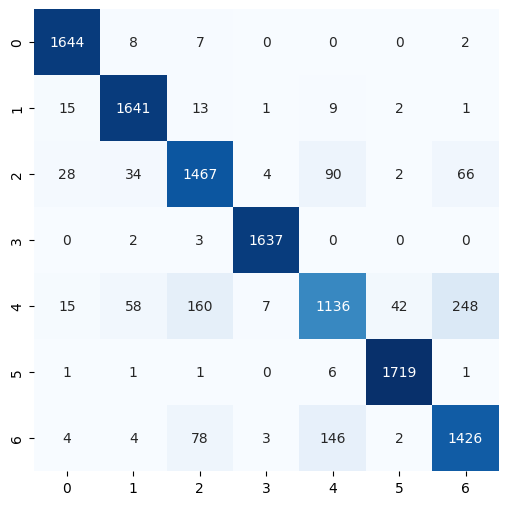

In [33]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, x_pred), annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.show()

**From the classification report we can conclude that class 4 i.e. "melanoma (mel)" has lowest accuracy and precision score which means model cannot predict it as good as others. Class 4 or Melanoma examples were highest in the initial dataset, but to compensate for lack of other classes the Tomek-link algorithm applied on it removed some of the outliers, which are important in medical diagnosis classification. Hence we get all the other classes with high accuracy and one with little less accuracy.**




In [34]:
print('classification report :-')
print(classification_report(y_test, x_pred))

classification report :-
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1661
           1       0.94      0.98      0.96      1682
           2       0.85      0.87      0.86      1691
           3       0.99      1.00      0.99      1642
           4       0.82      0.68      0.74      1666
           5       0.97      0.99      0.98      1729
           6       0.82      0.86      0.84      1663

    accuracy                           0.91     11734
   macro avg       0.91      0.91      0.91     11734
weighted avg       0.91      0.91      0.91     11734



**Saved the final model in drive using save() method**

In [39]:
import os
folder_path = '/content/drive/MyDrive/Cancer Detection'
file_name = 'skin_lesion_final_model.h5'
model.save(os.path.join(folder_path, file_name))